In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), wrong dep version loaded (2), mismatched flags (16))


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [7]:
# Circle: returns true if (px, py) is inside the circle of radius r centered at (cx, cy)
circle_mask(px, py, cx, cy, r) = (px - cx)^2 + (py - cy)^2 <= r^2

# Cross: returns true if (px, py) is within the cross arms centered at (cx, cy) with arm length size and thickness t
function cross_mask(px, py, cx, cy, size, t)
    half = size / 2
    # Horizontal arm
    in_h = abs(py - cy) <= t/2 && abs(px - cx) <= half
    # Vertical arm
    in_v = abs(px - cx) <= t/2 && abs(py - cy) <= half
    return in_h || in_v
end

# Rasterize a random shape to a grid array
function raster_random_shape(rng::AbstractRNG; canvas_size=10, grid_size=128, cross_thickness=0.2)
    shape_type = rand(rng, ["cross", "circle"])
    vmap = Dict("cross" => 1, "circle" => 2)
    x = rand(rng) * canvas_size
    y = rand(rng) * canvas_size
    size = (0.5 + rand(rng)) * (canvas_size / 5)
    t = cross_thickness * size

    # Set up grid coordinates (center of each pixel)
    xs = range(0, canvas_size, length=grid_size)
    ys = range(0, canvas_size, length=grid_size)
    img = zeros(Float32, grid_size, grid_size, 1)

    for j in 1:grid_size, i in 1:grid_size
        px, py = xs[i], ys[j]
        if shape_type == "circle"
            img[j, i, 1] = circle_mask(px, py, x, y, size/2) ? 1 : 0
        else
            img[j, i, 1] = cross_mask(px, py, x, y, size, t) ? 1 : 0
        end
    end
    return img, vmap[shape_type]
end

raster_random_shape (generic function with 1 method)

In [8]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [9]:
args = Args(batchsize = 128, epochs = 25)

Args(0.001, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [10]:
function generate_dataset(rng::AbstractRNG, n::Int, args::Args)
    data = [raster_random_shape(rng) for i in 1:n];
    x = stack([d[1] for d in data]);
    y = onehotbatch(stack([d[2] for d in data]), 1:2);
    loader = DataLoader((x, y), batchsize = args.batchsize)
    return loader
end

generate_dataset (generic function with 1 method)

In [11]:
train_loader = generate_dataset(rng, 10000, args)

79-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [12]:
x0, y0 = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 1 1 … 1 1])

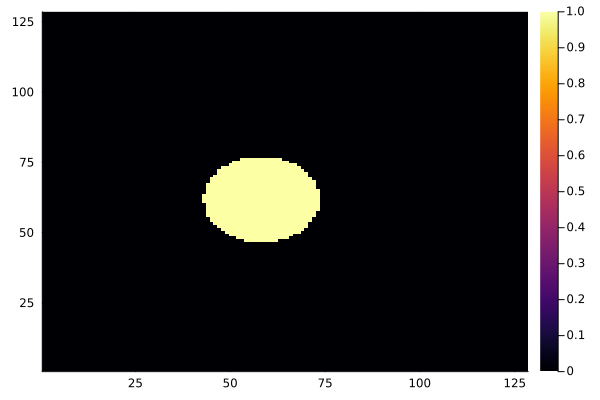

In [13]:
heatmap(x0[:,:,1,1])

In [14]:
y0[:,1]

2-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 1

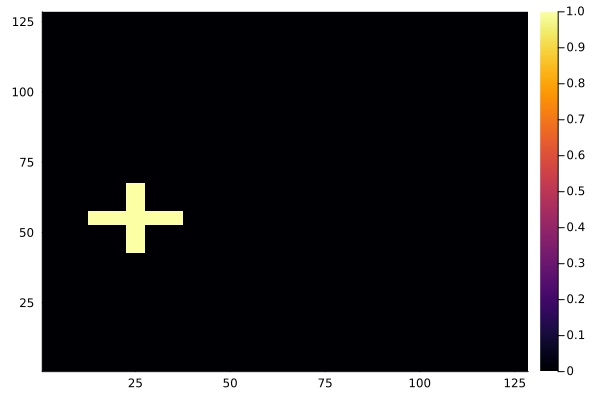

In [15]:
heatmap(x0[:,:,1,5])

In [16]:
y0[:,5]

2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

In [17]:
glorot_uniform

glorot_uniform (generic function with 8 methods)

In [18]:
gu = glorot_uniform
model = Chain(Conv((32,32), 1=>3, relu, pad=(1,1), init_weight=gu),
            MaxPool((2,2)),
            Dropout(0.3),

            Conv((16,16), 3=>1, relu, pad=(1,1), init_weight=gu),
            MaxPool((2,2)),
            FlattenLayer(),
            Dropout(0.4),

            Dense(324 => 16, relu, init_weight=gu),
            Dense(16 => 2, init_weight=gu),
            softmax)

Chain(
    layer_1 = Conv((32, 32), 1 => 3, relu, pad=1),  # 3_075 parameters
    layer_2 = MaxPool((2, 2)),
    layer_3 = Dropout(0.3),
    layer_4 = Conv((16, 16), 3 => 1, relu, pad=1),  # 769 parameters
    layer_5 = MaxPool((2, 2)),
    layer_6 = FlattenLayer{Nothing}(nothing),
    layer_7 = Dropout(0.4),
    layer_8 = Dense(324 => 16, relu),   # 5_200 parameters
    layer_9 = Dense(16 => 2),           # 34 parameters
    layer_10 = WrappedFunction(softmax),
)         # Total: 9_078 parameters,
          #        plus 4 states.

In [19]:
ps, st = Lux.setup(rng, model) .|> gdev

((layer_1 = (weight = Float32[0.02288661 -0.031938393 … -0.02341751 -0.031188289; 0.03685747 0.038181536 … 0.019481776 -0.020566864; … ; -0.0027223844 0.03174333 … -0.024424233 0.01584481; 0.022194123 -0.028018417 … 0.02765622 0.0019480088;;;; 0.0027930578 0.02923591 … 0.026197867 -0.029164525; -0.020759568 0.0045998427 … -0.010326101 0.030828018; … ; -0.03410996 -0.035301827 … -0.006682501 -0.032978516; -0.031655457 0.027965423 … 0.02292958 -0.037488863;;;; 0.02323208 -0.00045370715 … -0.03642979 -0.008727035; 0.027897386 -0.016972521 … -0.03662735 -0.032391123; … ; -0.0029395835 -0.028690953 … -0.0098925745 0.020827284; -0.011689928 -0.024264531 … 0.022041995 0.021654705], bias = Float32[0.025551282, 0.028959043, 0.02966293]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.012861654 -0.067856066 … -0.029699873 -0.060335986; 0.03250122 -0.03394018 … 0.06978148 -0.00790046; … ; -0.072153695 -0.06254831 … 0.01569484 -0.07375227; 0.0034279204 -0.070731655 

In [20]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y)
end

loss_function (generic function with 1 method)

In [21]:
x0 = x0 |> gdev
y0 = y0 |> gdev

2×128 OneHotMatrix(::CuArray{UInt32, 1, CUDA.DeviceMemory}) with eltype Bool:
 ⋅  ⋅  1  1  1  1  1  1  ⋅  ⋅  ⋅  1  ⋅  …  1  1  1  1  1  1  ⋅  1  ⋅  1  ⋅  ⋅
 1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  1

In [22]:
l, gs = withgradient(p -> loss_function(x0, y0, model, p, st), ps)

(val = 0.7249763f0, grad = ((layer_1 = (weight = Float32[0.043745656 0.04171261 … 0.013460592 0.018076466; 0.044601493 0.040480435 … 0.021855097 0.019413523; … ; -0.0037069607 -0.010062588 … -0.0013263933 0.009298461; -0.004963883 -0.004585109 … 0.010434884 0.007451484;;;; 0.04553052 0.050544128 … 0.04216861 0.042164184; 0.041868947 0.048152633 … 0.054853924 0.048848137; … ; 0.0056791506 0.004544202 … 0.026059575 0.028191835; 0.0054317336 0.008517861 … 0.024735354 0.025235511;;;; 0.053520437 0.038903695 … 0.016287126 0.015932165; 0.057420887 0.03762814 … 0.015418306 0.016749838; … ; 0.051572282 0.0459159 … 0.014900979 0.012833687; 0.05138396 0.045930337 … 0.023004634 0.022808298], bias = Float32[-0.08969635, 0.07664508, 0.060285985]), layer_2 = nothing, layer_3 = nothing, layer_4 = (weight = Float32[0.07332682 0.067616954 … 0.040508073 0.0071194265; 0.09141896 0.06853756 … 0.028022185 0.010110074; … ; 0.04035858 0.040704127 … 0.055064596 0.06351135; 0.04105371 0.046043664 … 0.037836995

In [23]:
losses, pst, stt = train(model, ps, st, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[0.7249763f0, 0.682287f0, 0.67403823f0, 0.7176765f0, 0.7062017f0, 0.71878535f0, 0.6835031f0, 0.69468504f0, 0.7020828f0, 0.71525097f0  …  0.0012511247f0, 0.0012378336f0, 0.0029941301f0, 0.0011407963f0, 0.0016083448f0, 0.0011997f0, 0.0011176639f0, 0.0016807143f0, 0.0012374958f0, 0.0012706711f0], (layer_1 = (weight = Float32[0.0116258785 -0.050997194 … 0.005322346 -0.03637049; -0.020615349 0.015790962 … 0.05210881 -0.023940284; … ; -0.00028592855 0.0734843 … -0.05269586 0.0153912045; -0.0014049801 -0.046194464 … 0.01803912 -0.027236065;;;; -0.056630347 -0.023268707 … -0.04440892 -0.23932359; -0.03635152 0.00012359522 … -0.02776425 -0.12403618; … ; -0.014374773 -0.030395834 … -0.1437081 -0.13589494; -0.075179055 -0.038758256 … -0.17641132 -0.30554888;;;; -0.09611389 -0.08763525 … -0.009436821 -0.026614245; -0.06715953 -0.080078475 … -0.056281462 -0.09765554; … ; -0.07425435 -0.1447737 … -0.07762925 0.04479276; -0.09332331 -0.15279484 … -0.081232086 -0.0036747225], bias = Float32[-0.000

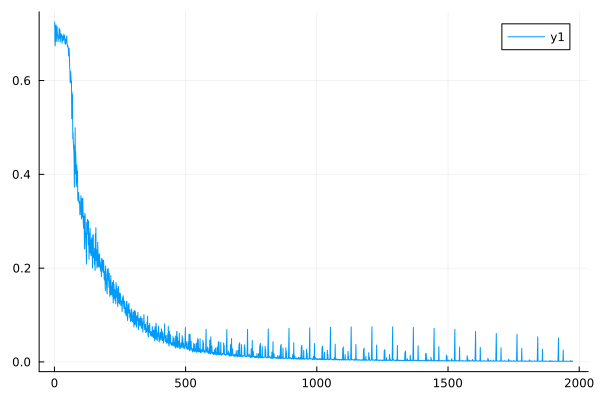

In [24]:
plot(losses)

In [25]:
yh1, _ = model(x0, pst, stt)

┌ Warning: `training` is set to `Val{true}()` but is not being used within an autodiff call (gradient, jacobian, etc...). This will be slow. If you are using a `Lux.jl` model, set it to inference (test) mode using `LuxCore.testmode`. Reliance on this behavior is discouraged, and is not guaranteed by Semantic Versioning, and might be removed without a deprecation cycle. It is recommended to fix this issue in your code.
└ @ LuxLib.Utils ~/.julia/packages/LuxLib/1B1qw/src/utils.jl:334


(Float32[0.0023311444 0.0023139159 … 0.002232217 0.0025025369; 0.9976688 0.997686 … 0.9977678 0.9974975], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (rng = Xoshiro(0xcfa08b14fbe490d2, 0x1cd3138b89e46d32, 0x1f592f22485609b7, 0xbe861015833ce9b2, 0xc90c4a0730db3f7e), training = Val{true}()), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple(), layer_7 = (rng = Xoshiro(0x6df5888af13c1452, 0xcc2ab7bd3a56f457, 0xf7eeb7fe69d69965, 0x1090144aa073c15b, 0xc90c4a0730db3f7e), training = Val{true}()), layer_8 = NamedTuple(), layer_9 = NamedTuple(), layer_10 = NamedTuple()))

In [26]:
test_loader = generate_dataset(rng, 1000, args)

8-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [ ]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        true_labels = onecold(y)
        
        total_correct += sum(pred_labels .== true_labels)
        total_samples += size(x, length(size(x)))
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [28]:
test(model, test_loader, ps, st)

0.491

In [29]:
test(model, test_loader, pst, stt)

1.0

# Replicate with Phasor Architecture

In [30]:
import Base.show

In [31]:
struct ComplexBias <: LuxCore.AbstractLuxLayer
    dims
    init_bias
end

function ComplexBias(dims::Tuple{Vararg{Int}}; init_bias = nothing)
    if init_bias == nothing
        init_bias = (rng, dims) -> ones(ComplexF32, dims)
    end

    return ComplexBias(dims, init_bias)
end

function Base.show(io::IO, b::ComplexBias)
    print(io, "ComplexBias($(b.dims))")
end

In [32]:
import .PhasorNetworks: LuxParams

In [33]:
function (b::ComplexBias)(x::AbstractArray{<:Complex}, params::LuxParams, state::NamedTuple)
    b = params.bias_real .+ 1.0f0im .* params.bias_imag
    return x .+ b
end

In [34]:
function (b::ComplexBias)(params::LuxParams, state::NamedTuple; offset::Real = 0.0, spk_args::SpikingArgs)
    b = params.bias_real .+ 1.0f0im .* params.bias_imag
    return t -> bias_current(b, t, offset, spk_args)
end


In [35]:
function Lux.initialparameters(rng::AbstractRNG, bias::ComplexBias)
    bias = bias.init_bias(rng, bias.dims)
    bias_real = real.(bias)
    bias_imag = imag.(bias)
    params = (bias_real = bias_real, bias_imag = bias_imag)
    return params
end

In [36]:
ComplexBias((1,2,4), init_bias=nothing)

ComplexBias((1, 2, 4))  # 16 parameters

In [37]:
struct PhasorConv <: LuxCore.AbstractLuxContainerLayer{(:conv, :bias)}
    conv
    bias
    return_solution::Bool
end

In [38]:
function PhasorConv(k::Tuple{Vararg{<:Integer}}, chs::Pair{<:Integer,<:Integer}; return_solution::Bool = false, init_bias = nothing, kwargs...)
    #construct the convolutional layer
    conv = Conv(k, chs, identity; kwargs...)
    bias = ComplexBias(([1 for _ in 1:length(k)]...,chs[2],), init_bias = init_bias)
    return PhasorConv(conv, bias, return_solution)
end

PhasorConv

In [39]:
pcl = PhasorConv((32, 32), 1 => 3, init_weight = gu)

PhasorConv(
    conv = Conv((32, 32), 1 => 3),      # 3_075 parameters
    bias = ComplexBias((1, 1, 3)),      # 6 parameters
)         # Total: 3_081 parameters,
          #        plus 0 states.

In [40]:
function (pc::PhasorConv)(x, ps, st)
    x = angle_to_complex(x)
    x_real = real.(x)
    x_imag = imag.(x)

    conv_call = x -> pc.conv(x, ps.conv, st.conv)[1]
    y_real = conv_call(x_real)
    y_im = 1.0f0im .* conv_call(x_imag)
    y = y_real .+ y_im
    y = pc.bias(y, ps.bias, st.bias)
    y = complex_to_angle(y)
    
    return y, NamedTuple()
end

In [41]:
pcl.conv

Conv((32, 32), 1 => 3)  # 3_075 parameters

In [42]:
m1 = Chain(PhasorConv((32, 32), 1 => 3),)

Chain(
    layer_1 = PhasorConv(
        conv = Conv((32, 32), 1 => 3),  # 3_075 parameters
        bias = ComplexBias((1, 1, 3)),  # 6 parameters
    ),
)         # Total: 3_081 parameters,
          #        plus 0 states.

In [43]:
psp, stp = Lux.setup(rng, m1) .|> gdev

((layer_1 = (conv = (weight = Float32[-0.042241786 -0.03718051 … -0.019810857 -0.039427817; -0.037659954 -0.043666065 … 0.0136305485 -0.025717601; … ; -0.02633971 -0.05171345 … 0.008508647 0.044772528; 0.017765054 -0.017884322 … -0.039293654 0.050492827;;;; 0.031181585 -0.015901377 … -0.047276367 0.00090252835; 0.03158122 -0.030616207 … 0.0067469566 0.003334906; … ; -0.025021834 0.035103187 … -0.03772958 -0.008640218; 0.027716849 0.023123108 … -0.026383094 -0.022605104;;;; 0.0019978734 0.052810177 … 0.04353891 -0.012548992; -0.043681998 -0.048738692 … -0.0023254422 -0.016764244; … ; 0.027033968 0.030642359 … -0.03822548 0.04500478; -0.026002571 -0.052277397 … 0.01978877 0.029310029], bias = Float32[-0.0018886551, -0.028439384, 0.007677097]), bias = (bias_real = Float32[1.0;;; 1.0;;; 1.0], bias_imag = Float32[0.0;;; 0.0;;; 0.0])),), (layer_1 = (conv = NamedTuple(), bias = NamedTuple()),))

In [47]:
yp0, _ = m1(x0, psp, stp);

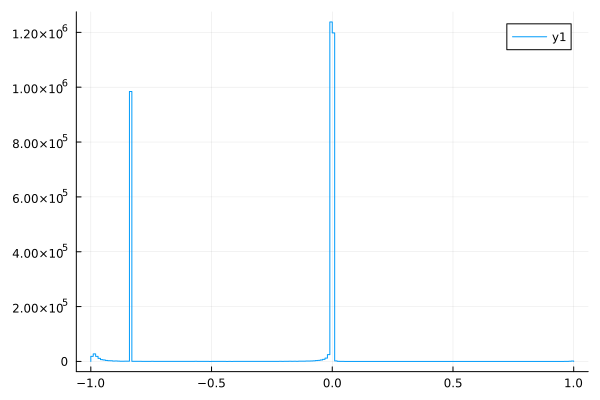

In [48]:
histogram(cdev(vec(yp0)))

In [64]:
struct MinPool <: LuxCore.AbstractLuxWrapperLayer{:pool}
    pool
end

function MinPool()
    return MinPool(MaxPool())
end

function (mp::MinPool)(x, ps, st)
    y = -1.0f0 .* mp(-1.0f0 .* x, ps, st)
    return y
end 

In [83]:
p_model = Chain(
            x -> 0.5f0 .* x,
            PhasorConv((32,32), 1=>3, pad=(1,1), init_weight=gu),
            #MaxPool((2,2)),
            #Dropout(0.3),

            PhasorConv((16,16), 3=>1, pad=(1,1), init_weight=gu),
            #MaxPool((2,2)),
            FlattenLayer(),
            #Dropout(0.4),
            
            PhasorDense(7396 => 16, init_weight=gu),
            PhasorDense(16 => 2, init_weight=gu),
            )

Chain(
    layer_1 = WrappedFunction(#35),
    layer_2 = PhasorConv(
        conv = Conv((32, 32), 1 => 3, pad=1),  # 3_075 parameters
        bias = ComplexBias((1, 1, 3)),  # 6 parameters
    ),
    layer_3 = PhasorConv(
        conv = Conv((16, 16), 3 => 1, pad=1),  # 769 parameters
        bias = ComplexBias((1, 1, 1)),  # 2 parameters
    ),
    layer_4 = FlattenLayer{Nothing}(nothing),
    layer_5 = PhasorDense((7396, 16)),  # 118_368 parameters
    layer_6 = PhasorDense((16, 2)),     # 36 parameters
)         # Total: 122_256 parameters,
          #        plus 0 states.

In [84]:
pps, pst = Lux.setup(rng, p_model) .|> gdev

((layer_1 = NamedTuple(), layer_2 = (conv = (weight = Float32[-0.026428685 -0.008901114 … -0.029569814 -0.0136667; 0.020515313 0.027280292 … 0.022221914 -0.02091557; … ; 0.03029965 -0.019669995 … -0.00703221 0.03735517; 0.019749876 -0.027195724 … -0.037765324 0.0076868962;;;; 0.004495744 -0.03623121 … 0.0109752035 -0.0030250351; 0.001080982 -0.014967212 … -0.020451387 0.03103189; … ; 0.031631038 0.007035992 … -0.026119081 0.013759747; 0.0253361 -0.033669397 … -0.037168488 -0.023263274;;;; 0.028903592 0.014973705 … -0.004749211 0.022894097; -0.032548003 -0.00061069924 … 0.02132904 -0.023763096; … ; 0.019868957 0.027945321 … 0.017635366 -0.027979298; -0.0123442905 0.005955384 … 0.0056506027 -0.015327688], bias = Float32[0.028427847, -0.024588604, 0.005157873]), bias = (bias_real = Float32[1.0;;; 1.0;;; 1.0], bias_imag = Float32[0.0;;; 0.0;;; 0.0])), layer_3 = (conv = (weight = Float32[0.03800856 -0.06844202 … 0.041691635 0.05732603; -0.06350336 -0.035158493 … 0.010632739 0.027593654; … ;

In [85]:
yhp0, _ = p_model(x0, pps, pst)

(Float32[-0.012342087 -0.037235744 … -0.0025630605 -0.078654945; -0.014397962 -0.06770798 … 0.012875491 -0.062364966], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

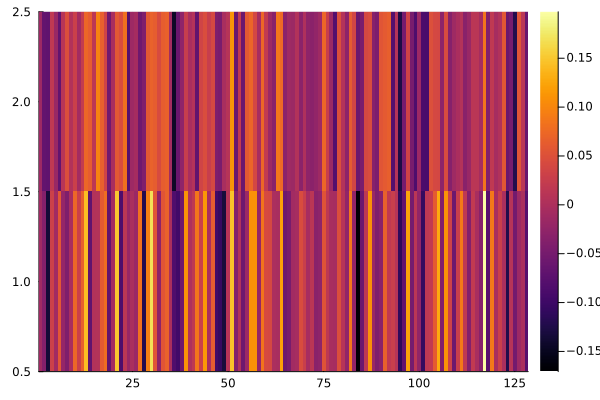

In [87]:
heatmap(yhp0 |> cdev)

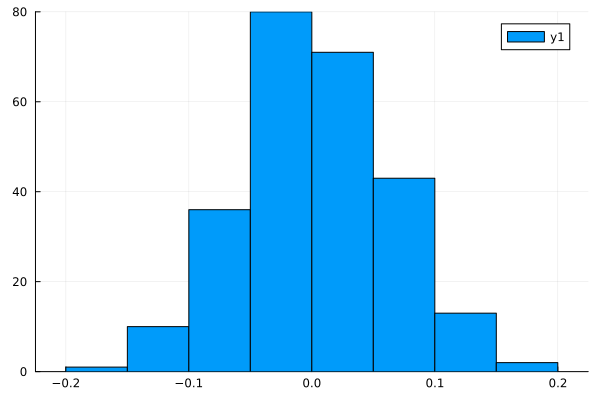

In [88]:
histogram(vec(cdev(yhp0)))

In [89]:
quadrature_loss(yhp0, y0) |> mean

0.50772876f0

In [90]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    loss = quadrature_loss(y_pred, y) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 2 methods)

In [91]:
l2, gs2 = withgradient(p -> phasor_loss_function(x0, y0, p_model, p, pst), pps)

(val = 0.50772876f0, grad = ((layer_1 = nothing, layer_2 = (conv = (weight = Float32[-0.0044642035 -0.00196719 … 0.002516395 0.00097600534; -0.005190115 -0.0006579417 … -0.00066717726 -0.0019178037; … ; 0.0025918004 0.00088088535 … 0.004692931 0.00368964; -0.00044148462 0.0008645332 … 0.006894182 0.0073591555;;;; -0.0016467411 -0.0040265545 … 0.0046117967 0.004785316; 0.0012296451 -0.0046061715 … 0.006661666 0.0054779155; … ; 0.011211125 0.010884382 … -0.012437165 -0.011086665; 0.011491665 0.010372166 … -0.0088104345 -0.008918161;;;; -0.003787095 -0.0030827778 … 0.004487041 0.0010354746; -0.0042846855 -0.0036289762 … 0.0021503533 -0.00016893935; … ; 0.0014272744 0.0018941616 … -0.0037848193 -0.0031141262; 0.002228766 0.00213315 … 0.00071514724 0.001400811], bias = Float32[-0.004365677, 0.13793263, -0.011642282]), bias = (bias_real = Float32[0.00043207442;;; -0.0015745395;;; -0.0012678207], bias_imag = Float32[-0.004797739;;; 0.13950717;;; -0.010374452])), layer_3 = (conv = (weight = Fl

In [92]:
p_losses, ppst, pstp = train(p_model, pps, pst, train_loader, phasor_loss_function, args, optimiser=Optimisers.RMSProp)

[ Info: Training on CUDA GPU


(Any[0.50772876f0, 0.50198454f0, 0.4934826f0, 0.49316135f0, 0.4933175f0, 0.4930812f0, 0.49039236f0, 0.48893446f0, 0.48791325f0, 0.4930258f0  …  0.24325062f0, 0.19858575f0, 0.18755916f0, 0.21947533f0, 0.19173673f0, 0.16158268f0, 0.17340213f0, 0.23201203f0, 0.27678713f0, 0.1437753f0], (layer_1 = NamedTuple(), layer_2 = (conv = (weight = Float32[-0.058703415 -0.042582743 … -0.06794878 -0.051527563; -0.0094687985 -0.0027654776 … -0.0075765215 -0.051051136; … ; 0.029447041 -0.0141603835 … -0.018404607 0.014828781; 0.04060143 -0.0051893946 … -0.036583595 -0.005127238;;;; -0.013554192 -0.03297844 … 0.006373967 -0.015122583; -0.047654666 -0.03913408 … -0.050760336 -0.0049583106; … ; 0.017812274 -0.002573651 … -0.034081183 -0.0030100802; 0.011837906 -0.044079896 … -0.03928101 -0.033353575;;;; 0.0135470955 0.010196206 … -0.0018902917 0.02006515; -0.05258217 -0.010035364 … 0.01570962 -0.028391834; … ; 0.0032884968 0.010307296 … -0.017447026 -0.061430376; -0.012461076 0.0065803626 … -0.017019087 -

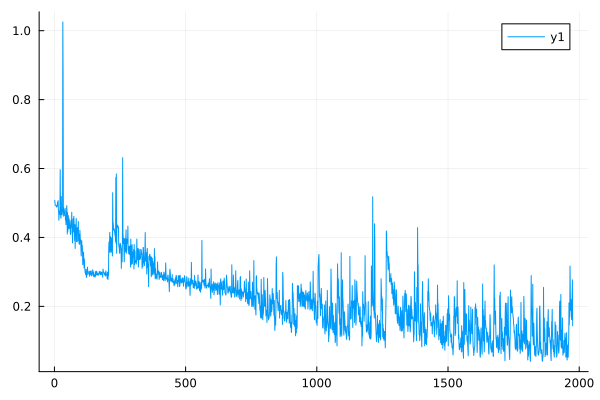

In [93]:
plot(p_losses)

In [94]:
yhp1, _ = p_model(x0, ppst, pstp)

(Float32[0.0041528326 -0.012744191 … 0.34426963 0.3220268; 0.47789383 0.3342259 … -0.009307463 0.18659112], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

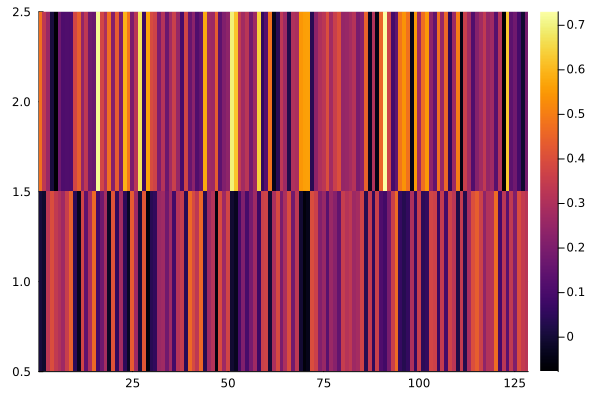

In [95]:
heatmap(yhp1 |> cdev)

In [96]:
loss_and_accuracy(test_loader, p_model, ppst, pstp, args)

(0.16573773f0, 0.795)

In [78]:
stop

LoadError: UndefVarError: `stop` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
yp0, stp0 = m1(x0 .* 0.5f0, psp, stp)

(97, 97, 3, 128)


(Float32[0.0016389295 0.0016389304 … 0.0016389237 0.0016389231; 0.0016389211 0.0016389191 … 0.0016389241 0.0016389233; … ; 0.0016389079 0.00163891 … 0.0016389139 0.0016389131; 0.0016389289 0.0016389268 … 0.0016389219 0.0016389206;;; 0.005586458 0.005586458 … 0.005586459 0.005586459; 0.00558646 0.0055864584 … 0.0055864574 0.0055864546; … ; 0.0055864523 0.0055864514 … 0.0055864523 0.0055864537; 0.005586458 0.005586459 … 0.005586458 0.005586456;;; -0.0133876875 -0.013387687 … -0.013387698 -0.0133877; -0.013387692 -0.013387697 … -0.013387722 -0.013387715; … ; -0.013387721 -0.0133877145 … -0.013387678 -0.0133876745; -0.0133877145 -0.013387717 … -0.013387678 -0.013387684;;;; 0.001638917 0.0016389191 … 0.0016389214 0.001638922; 0.0016389228 0.001638926 … 0.0016389182 0.0016389198; … ; 0.0016389057 0.001638905 … 0.0016389246 0.001638924; 0.0016389148 0.0016389143 … 0.0016389225 0.0016389198;;; 0.005586446 0.0055864546 … 0.005586454 0.0055864523; 0.0055864556 0.005586461 … 0.0055864514 0.005586

In [ ]:
cx0 = angle_to_complex(x0 .* 0.5f0);

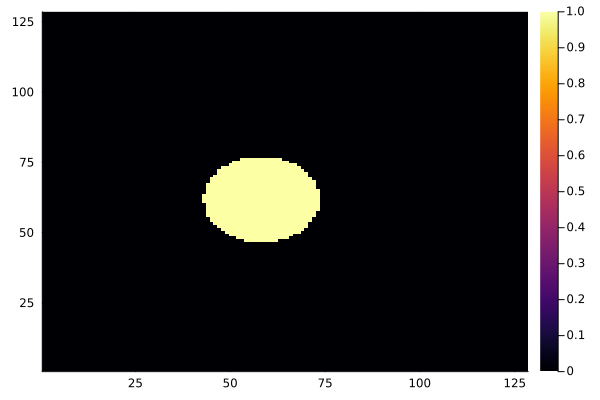

In [ ]:
heatmap(imag.(cdev(cx0[:,:,1,1])))

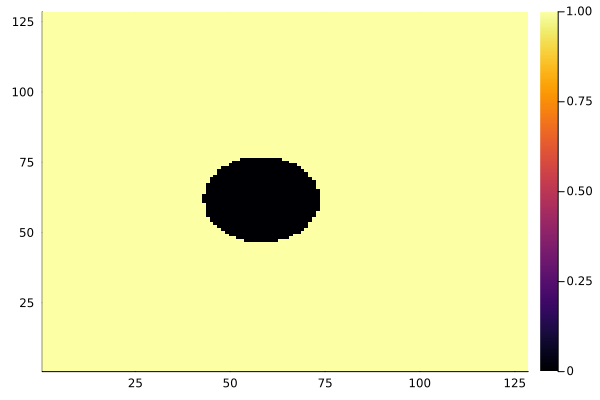

In [ ]:
heatmap(real.(cdev(cx0[:,:,1,1])))